In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

### Base case calulations

In [ ]:
import geopandas as gpd

building_centroids = gpd.read_file("/content/buildings_cadastre_centroid_2024.shp")
pois = gpd.read_file("/content/all_pois.shp")
pedestrian_network = gpd.read_file("/content/pedestrian_network_26_2020.shp")

crs = "EPSG:32635"
building_centroids = building_centroids.to_crs(crs)
pois = pois.to_crs(crs)
pedestrian_network = pedestrian_network.to_crs(crs)


building_centroids['population_density'] = building_centroids.geometry.apply(
    lambda x: building_centroids[building_centroids.geometry.distance(x) < 500].shape[0]
)
building_centroids['distance_to_poi'] = building_centroids.geometry.apply(
    lambda x: pois.distance(x).min()
)
admin_regions = gpd.read_file("/content/adm_regions.shp")
admin_regions = admin_regions.to_crs(crs)

print(admin_regions.columns)
print(admin_regions.head())


In [ ]:

# Calculations using the administrative regions
from scipy.stats import entropy

def calculate_land_use_mix(polygon, admin_regions):
    interesting_regions = admin_regions[admin_regions.intersects(polygon)]
    load_use_counts = interesting_regions['obns_cyr'].value_counts()
    return entropy(load_use_counts)

building_centroids['land_use_mix'] = building_centroids.geometry.apply(
    lambda x: calculate_land_use_mix(x.buffer(500), admin_regions)
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for column in ['population_density', 'distance_to_poi', 'land_use_mix', 'pedestrian_density', 'connectivity']:
    building_centroids[f'norm_{column}'] = scaler.fit_transform(building_centroids[[column]])

# Calculate the walkability index as an average of the normalized scores (Same weight)
building_centroids['walkability_index'] = (
    building_centroids['norm_population_density'] +
    building_centroids['norm_distance_to_poi'] +
    building_centroids['norm_land_use_mix'] +
    building_centroids['norm_pedestrian_density'] +
    building_centroids['norm_connectivity']
) / 5


In [ ]:
import matplotlib.pyplot as plt

building_centroids.plot(column='walkability_index', cmap='viridis', legend=True)
plt.title("Walkability Index for Sofia")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Neural Network

In [ ]:

import geopandas as gpd
import pandas as pd

pois_shp_path = '/content/all_pois.shp' # Replace with your file path
pedestrian_network_shp_path = '/content/pedestrian_network_26_2020.shp'
buildings_residential_shp_path = '/content/buildings_all_residential_2024.shp'
land_use_gpkg_path = '/content/BG001L2_SOFIA_UA2018_v013.gpkg'

pois_data = gpd.read_file(pois_shp_path)
pedestrian_network_data = gpd.read_file(pedestrian_network_shp_path)
buildings_residential_data = gpd.read_file(buildings_residential_shp_path)
land_use_data = gpd.read_file(land_use_gpkg_path)

form_data_path = '/content/form_.xlsx'
form_data = pd.read_excel(form_data_path)


social_media_data_path = '/content/Reformatted_CSV_Data.csv'  # Replace with your file path
social_media_data = pd.read_csv(social_media_data_path)
pois_data.head(), pedestrian_network_data.head(), buildings_residential_data.head(), form_data.head(), social_media_data.head()


In [ ]:
# Generalised sentiment analysis of the social media posts
from transformers import pipeline
import pandas as pd

# Initialize the pre-trained sentiment analysis pipeline from Hugging Face
# Using the SST-2 model fine-tuned for sentiment analysis
sentiment_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")
MAX_TEXT_LENGTH = 512

def analyze_sentiment(text):
    if pd.notnull(text):
        # Trim text to fit within the model's maximum sequence length
        text = str(text)[:MAX_TEXT_LENGTH]
        return sentiment_analyzer(text)[0]['label']
    return 'NEUTRAL'

social_media_data['sentiment'] = social_media_data['Message'].apply(analyze_sentiment)

unique_labels = social_media_data['sentiment'].unique()
print(f"Unique labels returned by the model: {unique_labels}")
label_mapping = {
    'NEGATIVE': -1,  # Label returned for negative sentiment
    'POSITIVE': 1,   # Label returned for positive sentiment
    'NEUTRAL': 0     # Custom label for handling neutral or missing data
}

social_media_data['sentiment_score'] = social_media_data['sentiment'].map(label_mapping)
print(social_media_data[['Message', 'sentiment', 'sentiment_score']].head())


In [ ]:

buildings_residential_data['centroid'] = buildings_residential_data.geometry.centroid
pois_data['centroid'] = pois_data.geometry.centroid

buildings_residential_data['distance_to_poi'] = buildings_residential_data['centroid'].apply(
    lambda point: pois_data.distance(point).min())

pedestrian_network_data['centroid'] = pedestrian_network_data.geometry.centroid
buildings_residential_data['distance_to_pedestrian'] = buildings_residential_data['centroid'].apply(
    lambda point: pedestrian_network_data.distance(point).min())

building_density = buildings_residential_data['geometry'].area.sum() / buildings_residential_data['geometry'].area.count()
buildings_residential_data[['distance_to_poi', 'distance_to_pedestrian']].head()


In [ ]:

from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt

land_use_gpkg_path = '/content/BG001L2_SOFIA_UA2018_v013.gpkg'
land_use_data = gpd.read_file(land_use_gpkg_path, layer='BG001L2_SOFIA_UA2018')
print(f"CRS of land use data: {land_use_data.crs}")
minx, miny, maxx, maxy = (23.250, 42.650, 23.350, 42.750)  # WGS 84 coordinates
bbox = gpd.GeoDataFrame({'geometry': [box(minx, miny, maxx, maxy)]}, crs="EPSG:4326")
bbox = bbox.to_crs(land_use_data.crs)
land_use_within_bbox = land_use_data[land_use_data.geometry.intersects(bbox.iloc[0].geometry)].copy()
tolerance_value = 0.001  # Adjust based on the CRS and map scale
land_use_within_bbox['simplified_geometry'] = land_use_within_bbox.geometry.simplify(tolerance=tolerance_value)
land_use_within_bbox.set_geometry('simplified_geometry', inplace=True)
land_use_within_bbox['population_density'] = land_use_within_bbox['Pop2018'] / land_use_within_bbox['area']
print(land_use_within_bbox[['class_2018', 'area', 'Pop2018', 'simplified_geometry']].head())
minx, miny, maxx, maxy = land_use_within_bbox.total_bounds  # Get bounding box of the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # Increase the plot size
land_use_within_bbox.plot(
    column='population_density',
    ax=ax,
    legend=True,
    cmap='viridis',
    linewidth=0.5,
    alpha=0.8
)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])
plt.title("Population Density in Land Use Areas (Simplified Geometry)")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.show()



In [ ]:
from sklearn.preprocessing import LabelEncoder
walkability_columns = [
    'Какво е състоянието на тротоарите около жилищната сграда, за която попълвате въпросника?',
    'Достатъчно широки ли са тротоарите?\n',
    'Има ли препятствия по тротоарите (предмети, корени на дървета и др.)\n',
    'Има ли паркирани автомобили по тротоарите?\n',
    'Чувствате ли се в безопасност, докато се разхождате в квартала, където се намира жилищната сграда, за която попълвате въпросника?',
    'Има ли сенчести места, места за сядане и отдих, кошчета за отпадъци и др., правещи ходенето Ви в квартала по-удобно и комфортно?',
    'Има ли пешеходни пътеки, надлези или подлези на местата, където е необходимо?',
]
walkability_data = form_data[walkability_columns].fillna('')
label_encoder = LabelEncoder()
for column in walkability_data.columns:
    walkability_data[column] = label_encoder.fit_transform(walkability_data[column])
walkability_data.head()


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
walkability_data['cadregion'] = walkability_data['cadregion'].astype(str)
buildings_residential_data['cadregion'] = buildings_residential_data['cadregion'].astype(str)

predicted_walkability_df = pd.DataFrame({
    'cadregion': walkability_data['cadregion'],
    'predicted_walkability': predicted_walkability.flatten()
})

merged_data = pd.merge(buildings_residential_data, predicted_walkability_df, on='cadregion', how='left')

merged_data['predicted_walkability'].fillna(0, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_data.plot(column='predicted_walkability', cmap='coolwarm', legend=True, ax=ax)
plt.title("Predicted Walkability Index Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Regional Neural Network

In [ ]:
# Change file paths for spatial data
pois_shp_path = '/content/all_pois.shp'
pedestrian_network_shp_path = '/content/pedestrian_network_26_2020.shp'
buildings_residential_shp_path = '/content/buildings_all_residential_2024.shp'
land_use_gpkg_path = '/content/BG001L2_SOFIA_UA2018_v013.gpkg'

pois_data = gpd.read_file(pois_shp_path)
pedestrian_network_data = gpd.read_file(pedestrian_network_shp_path)
buildings_residential_data = gpd.read_file(buildings_residential_shp_path)

In [ ]:
# Load questionnaire data (Excel)
form_data_path = '/content/Walkability-Survey(1-96).xlsx'
form_data = pd.read_excel(form_data_path)

# Load social media data (CSV format)
social_media_data_path = '/content/Reformatted_CSV_Data.csv'
social_media_data = pd.read_csv(social_media_data_path)


In [ ]:
from transformers import pipeline

sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Define maximum text length to avoid exceeding model's input size
MAX_TEXT_LENGTH = 512

def analyze_sentiment(text):
    if pd.notnull(text):
        text = str(text)[:MAX_TEXT_LENGTH]
        result = sentiment_analyzer(text)[0]
        label = result['label']

        return int(label.split()[0])
    return 3  # Neutral score

social_media_data['sentiment_score'] = social_media_data['Message'].apply(analyze_sentiment)

print(social_media_data[['Message', 'sentiment_score']].head())


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

                                             Message  sentiment_score
0                                            Message                5
1  🛑 Хайде да си кажем истината - бул. Патриарх Е...                1
2  Прекарай с мен един ден на остров Сицилия❤️ 1....                4
3  Обещахме да няма повече ремонт на ремонтите. С...                5
4  Уикендът иде, ако си в София - ето няколко иде...                4


In [ ]:

buildings_residential_data['centroid'] = buildings_residential_data.geometry.centroid
pois_data['centroid'] = pois_data.geometry.centroid

buildings_residential_data['distance_to_poi'] = buildings_residential_data['centroid'].apply(
    lambda point: pois_data.distance(point).min())

pedestrian_network_data['centroid'] = pedestrian_network_data.geometry.centroid
buildings_residential_data['distance_to_pedestrian'] = buildings_residential_data['centroid'].apply(
    lambda point: pedestrian_network_data.distance(point).min())

buildings_residential_data['cadregion'] = buildings_residential_data['cadregion'].astype(str)

building_counts = buildings_residential_data.groupby('cadregion').size().rename('building_count')
region_areas = buildings_residential_data.dissolve(by='cadregion').area.rename('region_area')
building_density = building_counts / region_areas

building_density = building_density.reset_index()

buildings_residential_data = buildings_residential_data.merge(building_density, on='cadregion', how='left')

buildings_residential_data = buildings_residential_data.drop(columns=['centroid'])

buildings_residential_data.set_geometry('geometry', inplace=True)

# Save to a GeoPackage
buildings_residential_data.to_file('buildings_residential_data.gpkg', layer='buildings', driver='GPKG')

print("GeoDataFrame saved successfully.")


GeoDataFrame saved successfully.


load

In [ ]:
import geopandas as gpd

# Load the saved data
buildings_residential_data = gpd.read_file('buildings_residential_data.gpkg', layer='buildings')
print(buildings_residential_data.head())


  ekatte cadregion  cadimmovab  cadbuildin  rn_propert  rn_functyp  \
0  68134     705.0      1053.0         1.0         5.0       110.0   
1  68134    1007.0       899.0         2.0         5.0       100.0   
2  68134    1007.0       899.0         1.0         5.0       100.0   
3  68134     705.0      1065.0         1.0         5.0       110.0   
4  68134     403.0        12.0         1.0        11.0       110.0   

   floorcount  appcount  buildingar oldident                      func_type  \
0         3.0       3.0     119.248     None  Жилищна сграда - многофамилна   
1         1.0       0.0      25.926     None   Жилищна сграда - еднофамилна   
2         1.0       0.0      42.583     None   Жилищна сграда - еднофамилна   
3         1.0       2.0     136.498     None  Жилищна сграда - многофамилна   
4         9.0      51.0     447.090     None  Жилищна сграда - многофамилна   

   distance_to_poi  distance_to_pedestrian       0_x       0_y  \
0        48.523382               10.31

In [ ]:

land_use_data = gpd.read_file(land_use_gpkg_path, layer='BG001L2_SOFIA_UA2018')

minx, miny, maxx, maxy = (23.250, 42.650, 23.350, 42.750)

bbox = gpd.GeoDataFrame({'geometry': [box(minx, miny, maxx, maxy)]}, crs="EPSG:4326")

bbox = bbox.to_crs(land_use_data.crs)


land_use_within_bbox = land_use_data[land_use_data.geometry.intersects(bbox.iloc[0].geometry)].copy()

# Simplify geometry
tolerance_value = 0.001
land_use_within_bbox['simplified_geometry'] = land_use_within_bbox.geometry.simplify(tolerance=tolerance_value)

land_use_within_bbox.set_geometry('simplified_geometry', inplace=True)

land_use_within_bbox['area'] = land_use_within_bbox.geometry.area
land_use_within_bbox['population_density'] = land_use_within_bbox['Pop2018'] / land_use_within_bbox['area']

print(land_use_within_bbox[['class_2018', 'area', 'Pop2018', 'population_density']].head())


                                           class_2018          area  Pop2018  \
1   Discontinuous dense urban fabric (S.L. : 50% -...  12667.030750      204   
7              Continuous urban fabric (S.L. : > 80%)   6481.216432      143   
8              Continuous urban fabric (S.L. : > 80%)   4568.266248      133   
85  Industrial, commercial, public, military and p...   5818.551328        4   
88  Discontinuous dense urban fabric (S.L. : 50% -...   4675.025168       82   

    population_density  
1             0.016105  
7             0.022064  
8             0.029114  
85            0.000687  
88            0.017540  


In [ ]:
# Define the relevant columns related to walkability from the questionnaire using the actual column names
walkability_columns = [
    'Какво е състоянието на тротоарите около жилищната сграда, за която попълвате въпросника?',
    'Достатъчно широки ли са тротоарите?\n',
    'Има ли препятствия по тротоарите (предмети, корени на дървета и др.)\n',
    'Има ли паркирани автомобили по тротоарите?\n',
    'Чувствате ли се в безопасност, докато се разхождате в квартала, където се намира жилищната сграда, за която попълвате въпросника?',
    'Има ли сенчести места, места за сядане и отдих, кошчета за отпадъци и др., правещи ходенето Ви в квартала по-удобно и комфортно?',
    'Има ли пешеходни пътеки, надлези или подлези на местата, където е необходимо?'
]

walkability_data = form_data[walkability_columns].fillna('')

label_encoder = LabelEncoder()
for column in walkability_data.columns:
    walkability_data[column] = label_encoder.fit_transform(walkability_data[column])

walkability_data['walkability_score'] = walkability_data.mean(axis=1)

address_column = 'Въведете адрес на жилищната сграда, за която попълвате въпросника (град, вход, етаж и апартамент не са необходими, например: кв. Изток, ул. Незабравка 1 или кв. Дружба, Блок 170Б)'

geolocator = Nominatim(
    user_agent="walkability_index_sofia(your_email@example.com)", # Add your email for user agent
    timeout=10
)

geocode = RateLimiter(
    lambda address: geolocator.geocode(address + ', София, България', language='bg'),
    min_delay_seconds=1,
    max_retries=3,
    error_wait_seconds=2.0
)

def geocode_address(address):
    try:
        location = geocode(address)
        if location:
            return pd.Series({'latitude': location.latitude, 'longitude': location.longitude})
    except Exception as e:
        print(f"Error geocoding address '{address}': {e}")
    return pd.Series({'latitude': None, 'longitude': None})

geocoded_addresses = form_data[address_column].apply(geocode_address)

walkability_data = pd.concat([walkability_data, geocoded_addresses], axis=1)
walkability_data = walkability_data.dropna(subset=['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(walkability_data['longitude'], walkability_data['latitude'])]
walkability_gdf = gpd.GeoDataFrame(walkability_data, geometry=geometry, crs="EPSG:4326")

if buildings_residential_data.crs != "EPSG:4326":
    buildings_residential_data = buildings_residential_data.to_crs("EPSG:4326")

cadregions_gdf = buildings_residential_data.dissolve(by='cadregion').reset_index()

walkability_gdf = gpd.sjoin(
    walkability_gdf, cadregions_gdf[['cadregion', 'geometry']],
    how='left', predicate='within'
)


walkability_gdf = walkability_gdf.dropna(subset=['cadregion'])

walkability_gdf['cadregion'] = walkability_gdf['cadregion'].astype(str)

walkability_data = walkability_gdf

print(walkability_data.head())


    Какво е състоянието на тротоарите около жилищната сграда, за която попълвате въпросника?  \
1                                                   2                                          
7                                                   2                                          
11                                                  1                                          
14                                                  1                                          
17                                                  2                                          

    Достатъчно широки ли са тротоарите?\n  \
1                                       2   
7                                       1   
11                                      1   
14                                      0   
17                                      2   

    Има ли препятствия по тротоарите (предмети, корени на дървета и др.)\n  \
1                                                   1                     

In [ ]:

building_counts = buildings_residential_data.groupby('cadregion').size().rename('building_count')
region_areas = buildings_residential_data.dissolve(by='cadregion').area.rename('region_area')
building_density = building_counts / region_areas

building_density.name = 'building_density'

building_density = building_density.reset_index()

buildings_residential_data = buildings_residential_data.merge(
    building_density[['cadregion', 'building_density']], on='cadregion', how='left'
)


In [ ]:
!python -m spacy download xx_ent_wiki_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 64.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from transformers import pipeline
import spacy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

nlp = spacy.load('xx_ent_wiki_sm')

def analyze_sentiment(text):
    if pd.notnull(text):
        text = str(text)[:512]
        result = sentiment_analyzer(text)[0]
        label = result['label']
        return int(label.split()[0])
    return 3

social_media_data['sentiment_score'] = social_media_data['Message'].apply(analyze_sentiment)
def extract_location(text):
    if pd.notnull(text):
        text = str(text)
        doc = nlp(text)
        locations = [ent.text for ent in doc.ents if ent.label_ in ['LOC', 'GPE']]
        return locations
    else:
        return []

social_media_data['locations'] = social_media_data['Message'].apply(extract_location)

geolocator = Nominatim(user_agent="your_email@example.com", timeout=10) # Add your email for user agent
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def geocode_locations(locations):
    if locations and len(locations) > 0:
        for loc in locations:
            try:
                location = geocode(f"{loc}, Sofia, Bulgaria")
                if location:
                    return pd.Series({'latitude': location.latitude, 'longitude': location.longitude})
            except Exception:
                continue
    return pd.Series({'latitude': None, 'longitude': None})


geocoded_locations = social_media_data['locations'].apply(geocode_locations)
social_media_data = pd.concat([social_media_data, geocoded_locations], axis=1)

social_media_data = social_media_data.dropna(subset=['latitude', 'longitude'])

social_media_data['geometry'] = social_media_data.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)

social_media_gdf = gpd.GeoDataFrame(social_media_data, geometry='geometry', crs="EPSG:4326")


regions_gdf = buildings_residential_data.dissolve(by='cadregion').reset_index()
if regions_gdf.crs != "EPSG:4326":
    regions_gdf = regions_gdf.to_crs("EPSG:4326")

social_media_gdf = gpd.sjoin(
    social_media_gdf, regions_gdf[['cadregion', 'geometry']],
    how='left', predicate='within'
)
social_media_gdf = social_media_gdf.dropna(subset=['cadregion'])
social_media_gdf['cadregion'] = social_media_gdf['cadregion'].astype(str).str.strip()


aggregated_sentiment_all = social_media_gdf.groupby('cadregion').agg({
    'sentiment_score': 'mean'
}).reset_index()


In [ ]:

social_media_data = social_media_data.dropna(subset=['latitude', 'longitude'])
social_media_data['geometry'] = social_media_data.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
social_media_gdf = gpd.GeoDataFrame(social_media_data, geometry='geometry', crs="EPSG:4326")


if buildings_residential_data.crs != "EPSG:4326":
    buildings_residential_data = buildings_residential_data.to_crs("EPSG:4326")

regions_gdf = buildings_residential_data.dissolve(by='cadregion').reset_index()
if regions_gdf.crs != "EPSG:4326":
    regions_gdf = regions_gdf.to_crs("EPSG:4326")

social_media_gdf = gpd.sjoin(
    social_media_gdf, regions_gdf[['cadregion', 'geometry']],
    how='left', predicate='within'
)
social_media_gdf = social_media_gdf.dropna(subset=['cadregion'])
social_media_gdf['cadregion'] = social_media_gdf['cadregion'].astype(str).str.strip()


aggregated_sentiment_all = social_media_gdf.groupby('cadregion').agg({
    'sentiment_score': 'mean'
}).reset_index()


In [ ]:
print(buildings_residential_data.columns)


Index(['ekatte', 'cadregion', 'cadimmovab', 'cadbuildin', 'rn_propert',
       'rn_functyp', 'floorcount', 'appcount', 'buildingar', 'oldident',
       'func_type', 'distance_to_poi', 'distance_to_pedestrian', '0_x', '0_y',
       'geometry'],
      dtype='object')


In [ ]:

aggregated_buildings_all = buildings_residential_data.groupby('cadregion').agg({
    'distance_to_poi': 'mean',
    'distance_to_pedestrian': 'mean',
    'building_density': 'mean'
}).reset_index()

# Land use features
if 'cadregion' not in land_use_within_bbox.columns:
    land_use_within_bbox = land_use_within_bbox.to_crs(buildings_residential_data.crs)
    land_use_within_bbox = gpd.sjoin(
        land_use_within_bbox,
        buildings_residential_data[['cadregion', 'geometry']],
        how='left',
        predicate='intersects'
    )

if 'cadregion' in land_use_within_bbox.columns:
    land_use_within_bbox['cadregion'] = land_use_within_bbox['cadregion'].astype(str).str.strip()
    aggregated_land_use_all = land_use_within_bbox.groupby('cadregion').agg({
        'population_density': 'mean'
    }).reset_index()
else:
    average_population_density = land_use_within_bbox['population_density'].mean()
    aggregated_land_use_all = pd.DataFrame({
        'cadregion': aggregated_buildings_all['cadregion'],
        'population_density': average_population_density
    })

features_all_regions = pd.merge(
    aggregated_buildings_all, aggregated_land_use_all,
    on='cadregion', how='left'
)
features_all_regions = pd.merge(
    features_all_regions, aggregated_sentiment_all,
    on='cadregion', how='left'
)
features_all_regions = features_all_regions.fillna(0)
features_all_regions['cadregion'] = features_all_regions['cadregion'].astype(str).str.strip()


In [ ]:

walkability_data['cadregion'] = walkability_data['cadregion'].astype(str).str.strip()

# Prepare training data
merged_data_train = pd.merge(
    walkability_data[['cadregion', 'walkability_score']],
    features_all_regions,
    on='cadregion', how='inner'
)

feature_columns = [
    'distance_to_poi',
    'distance_to_pedestrian',
    'building_density',
    'population_density',
    'sentiment_score'
]

X_train = merged_data_train[feature_columns]
y_train = merged_data_train['walkability_score']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7.7573 - mae: 2.2687
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.4091 - mae: 1.9070
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8.6292 - mae: 2.4169
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.0415 - mae: 1.7130
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8893 - mae: 1.9384
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.4082 - mae: 1.7821
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 5.7477 - mae: 1.9370
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1662 - mae: 1.6403
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8316 - mae: 2.0568
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1464 - mae: 1.8429
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.7634 - mae: 2.2153
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.1312 - mae: 1.9580
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

In [ ]:
# Prepare features for all regions
X_all = features_all_regions[feature_columns]
X_all_scaled = scaler.transform(X_all)

predicted_walkability_all = model.predict(X_all_scaled)
features_all_regions['predicted_walkability'] = predicted_walkability_all.flatten()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:

regions_gdf['cadregion'] = regions_gdf['cadregion'].astype(str).str.strip()

regions_with_walkability = regions_gdf.merge(
    features_all_regions[['cadregion', 'predicted_walkability']],
    on='cadregion', how='left'
)

# Check for missing geometries and drop if necessary
regions_with_walkability = regions_with_walkability.dropna(subset=['geometry'])


In [ ]:
regions_with_walkability['predicted_walkability'] = pd.to_numeric(regions_with_walkability['predicted_walkability'], errors='coerce')


In [ ]:
# Identify regions with extreme negative values
extreme_negatives = regions_with_walkability[regions_with_walkability['predicted_walkability'] < -5]
print(extreme_negatives[['cadregion', 'predicted_walkability']])


    cadregion  predicted_walkability
73     1508.0             -13.080352
94     1897.0              -5.478894
197    4143.0             -21.093185
198    4144.0             -11.146191
199    4150.0              -9.466896
203    4166.0             -16.790165
238    4400.0              -5.687721


In [ ]:
# Cap the predicted_walkability values between -5 and 5
regions_with_walkability['predicted_walkability_capped'] = regions_with_walkability['predicted_walkability'].clip(lower=-5, upper=5)


In [ ]:
# Normalize the predicted_walkability values to 0-1 range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
regions_with_walkability['walkability_normalized'] = scaler.fit_transform(
    regions_with_walkability[['predicted_walkability_capped']]
)


In [ ]:
print(regions_with_walkability[['predicted_walkability', 'predicted_walkability_capped']].head())
print(regions_with_walkability['predicted_walkability_capped'].describe())


   predicted_walkability  predicted_walkability_capped
0              -0.196153                     -0.196153
1              -0.216473                     -0.216473
2              -0.041067                     -0.041067
3              -0.106227                     -0.106227
4              -0.185516                     -0.185516
count    321.000000
mean       0.250078
std        1.360146
min       -5.000000
25%       -0.192352
50%        0.121410
75%        1.016312
max        5.000000
Name: predicted_walkability_capped, dtype: float64


In [ ]:
print(regions_with_walkability['predicted_walkability_capped'].isna().sum())
print((regions_with_walkability['predicted_walkability_capped'] == 0).sum())


0
0


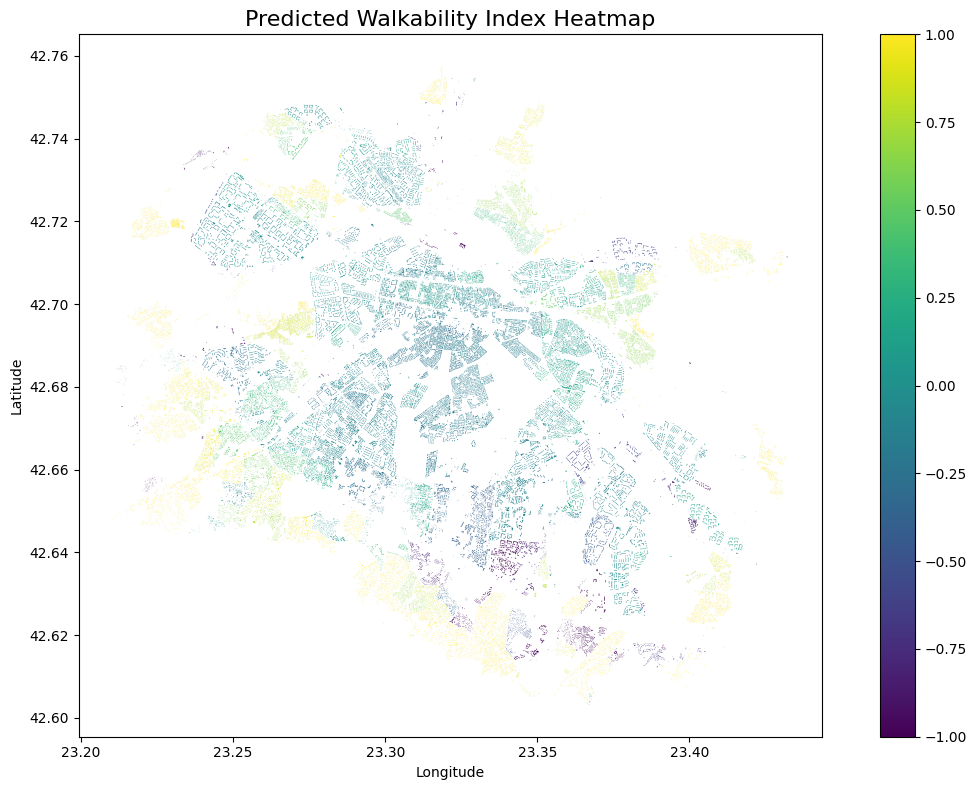

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
regions_with_walkability.plot(
    column='predicted_walkability_capped',
    cmap='viridis',
    legend=True,
    ax=ax,
    alpha=1.0,
    linewidth=0,
    vmin=-1,
    vmax=1
)
ax.set_title("Predicted Walkability Index Heatmap", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


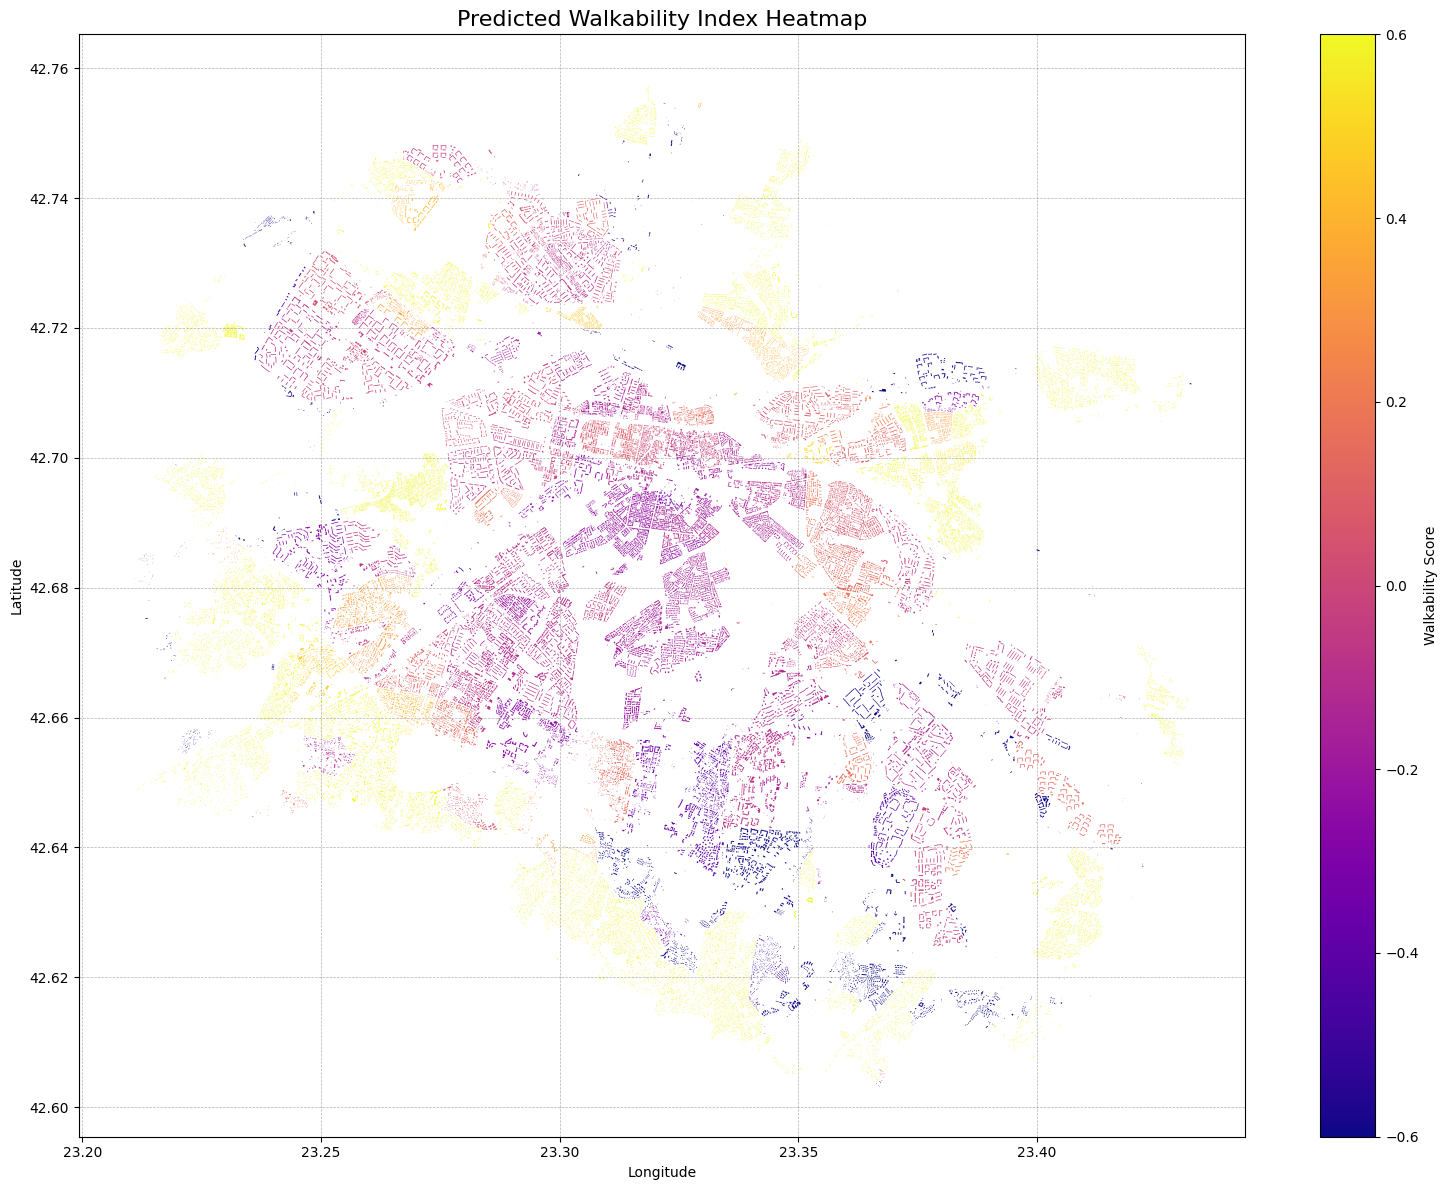

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

regions_with_walkability.plot(
    column='predicted_walkability_capped',
    cmap='plasma',
    legend=False,
    ax=ax,
    alpha=1.0,
    linewidth=0,
    vmin=-0.6,
    vmax=0.6
)

sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=-0.6, vmax=0.6))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Walkability Score')
ax.set_title("Predicted Walkability Index Heatmap", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)

plt.tight_layout()

plt.show()


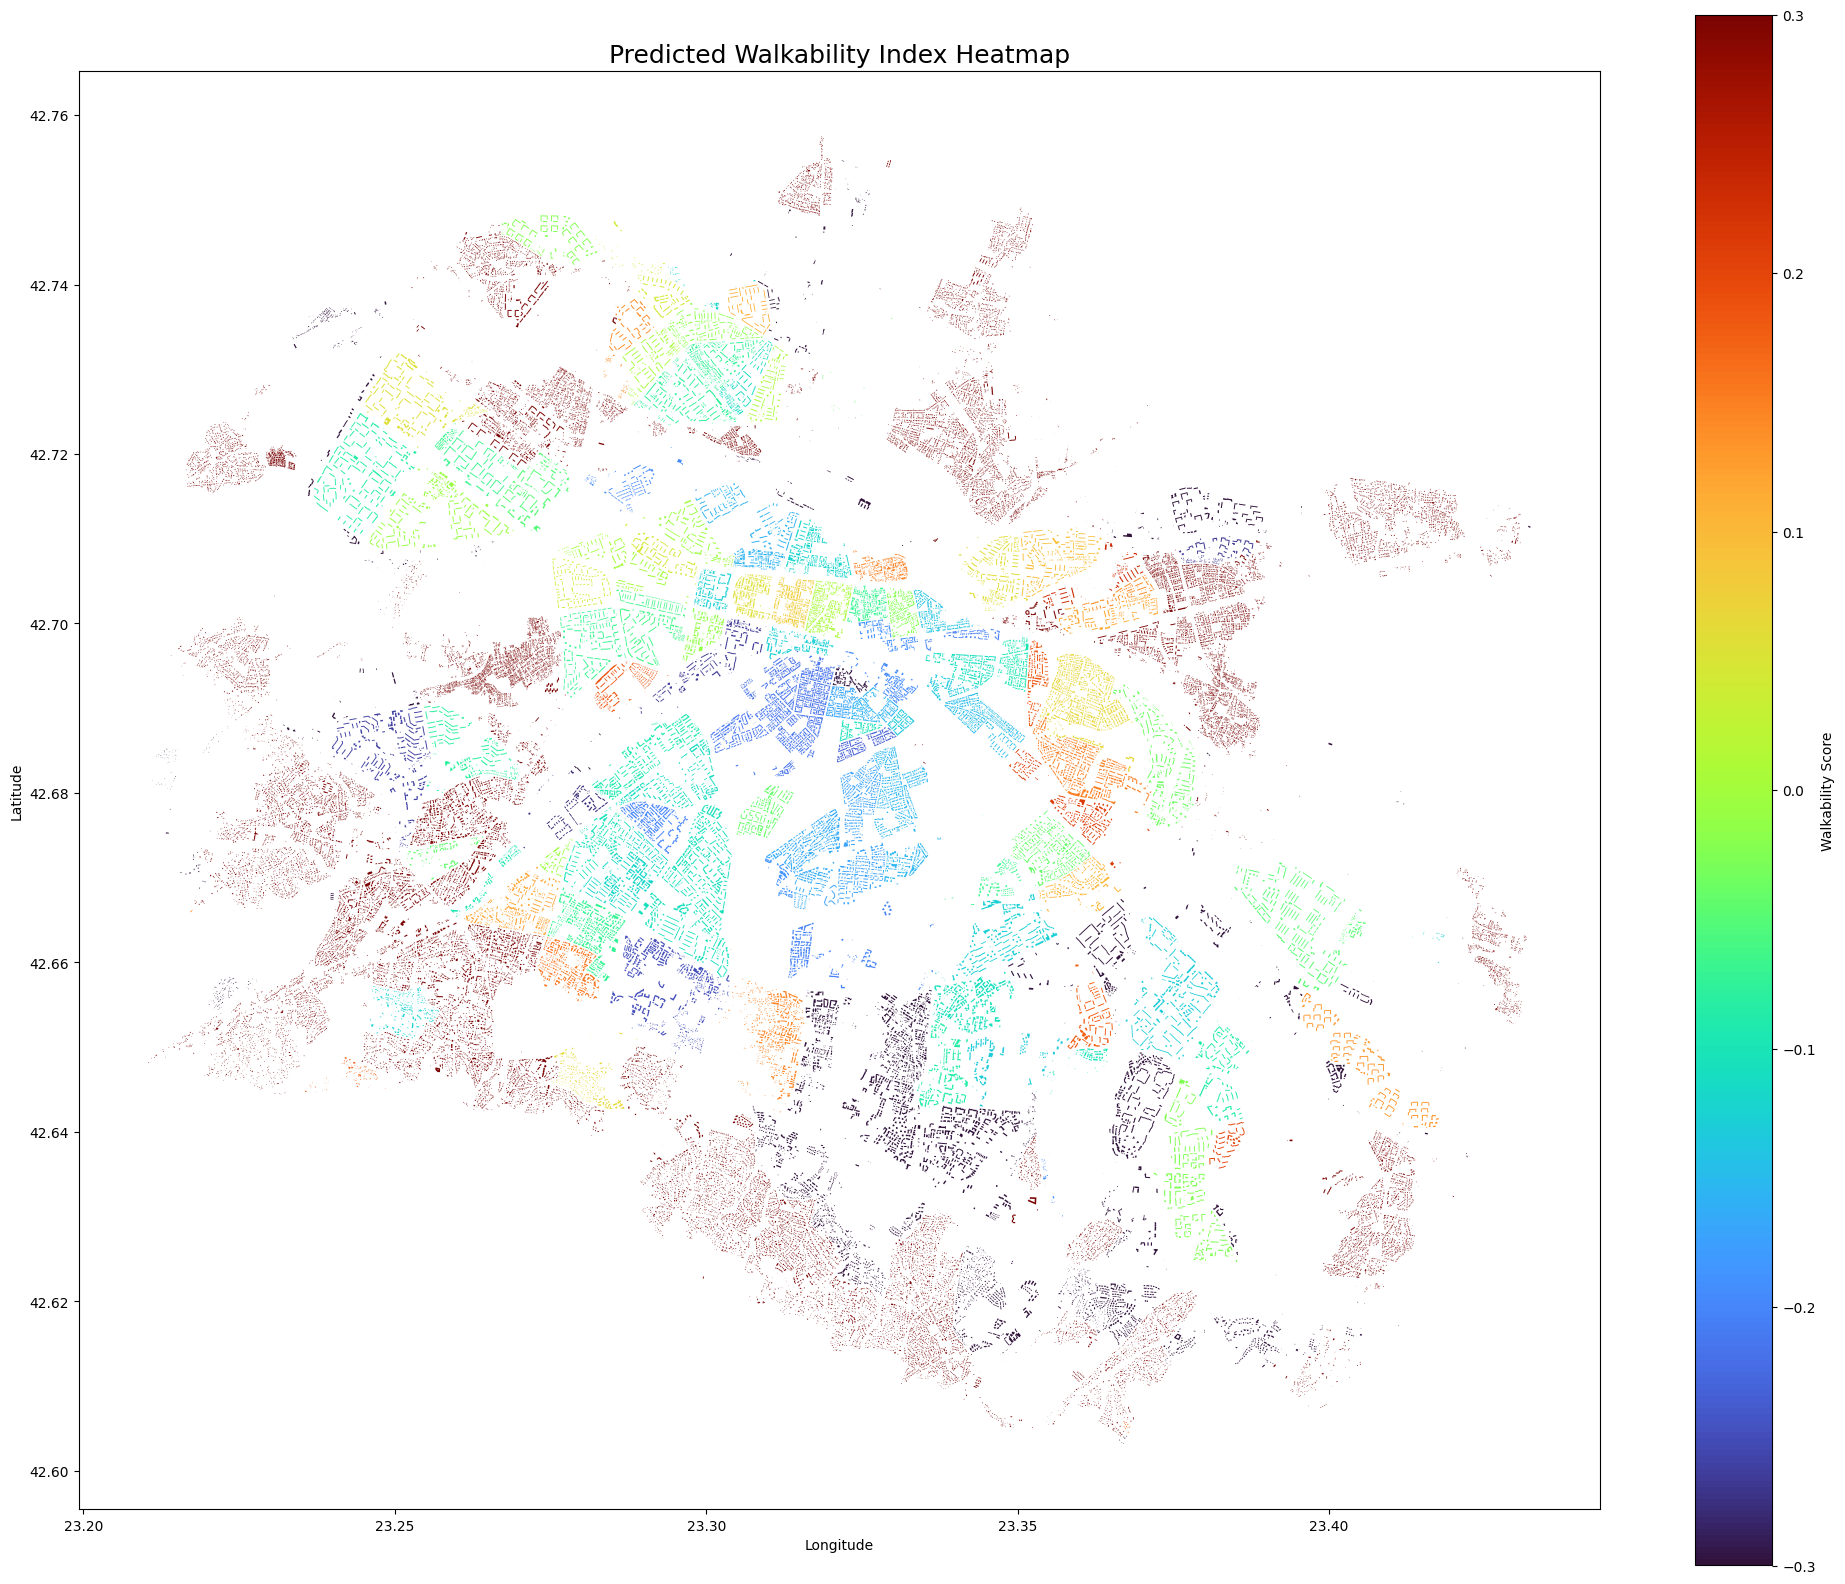

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

regions_with_walkability.plot(
    column='predicted_walkability_capped',
    cmap='turbo',
    legend=False,
    ax=ax,
    alpha=1.0,
    linewidth=0,
    vmin=-0.3,
    vmax=0.3
)

sm = plt.cm.ScalarMappable(cmap='turbo', norm=plt.Normalize(vmin=-0.3, vmax=0.3))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Walkability Score')
ax.set_title("Predicted Walkability Index Heatmap", fontsize=18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.grid(False)
plt.tight_layout()
plt.show()


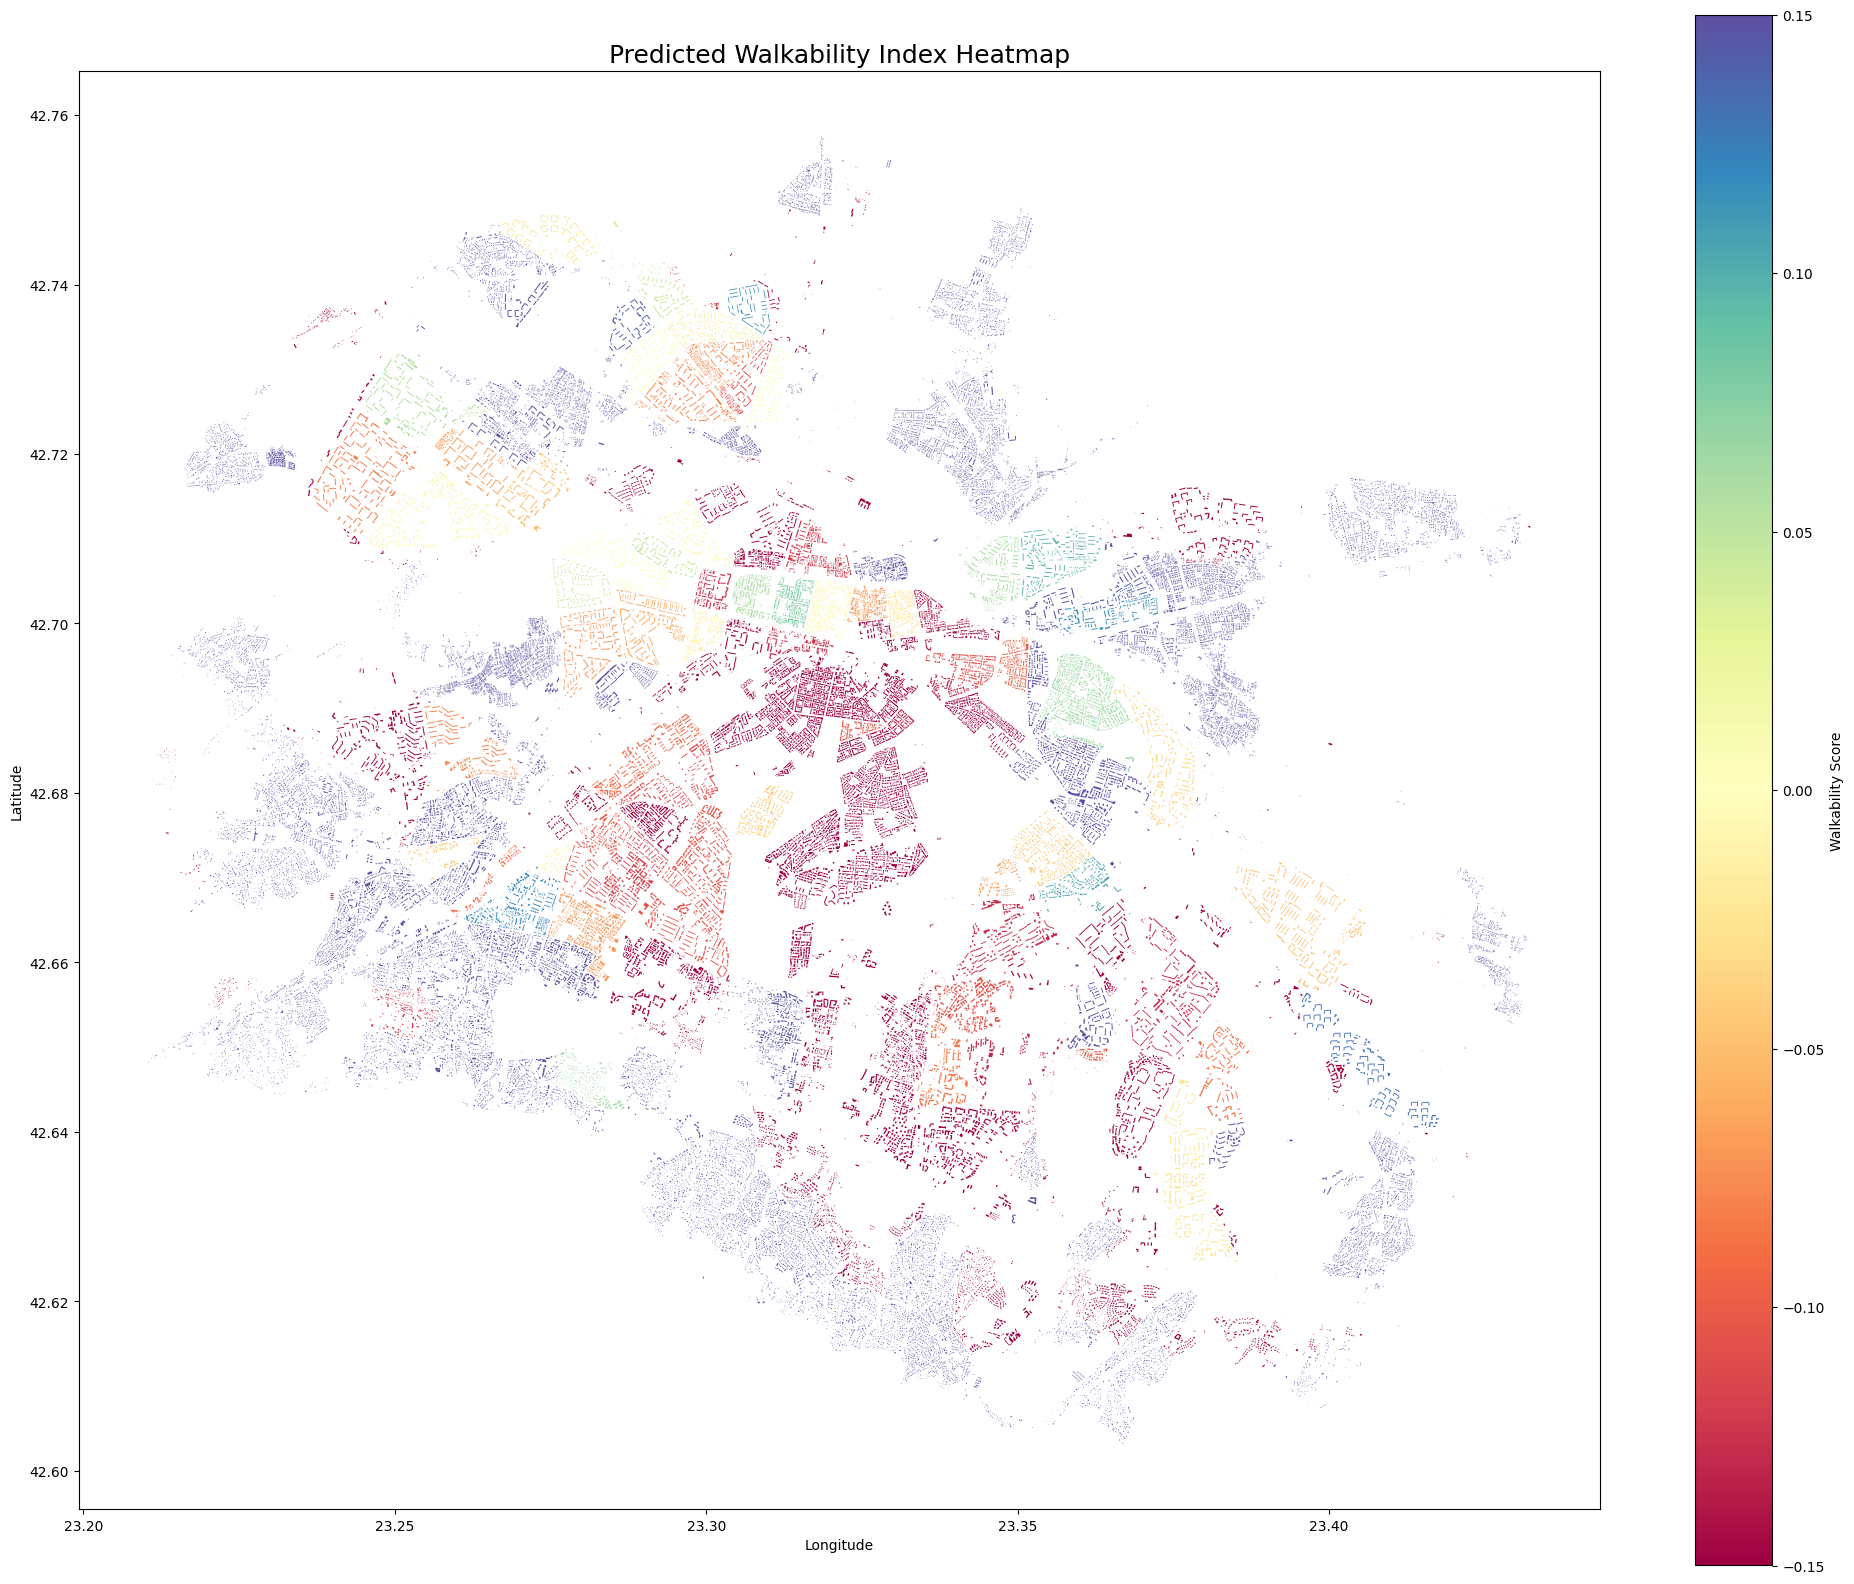

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

regions_with_walkability.plot(
    column='predicted_walkability_capped',
    cmap='Spectral',
    legend=False,
    ax=ax,
    alpha=1.0,
    linewidth=0,
    vmin=-0.15,
    vmax=0.15
)

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=-0.15, vmax=0.15))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Walkability Score')
ax.set_title("Predicted Walkability Index Heatmap", fontsize=18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(False)
plt.tight_layout()
plt.show()


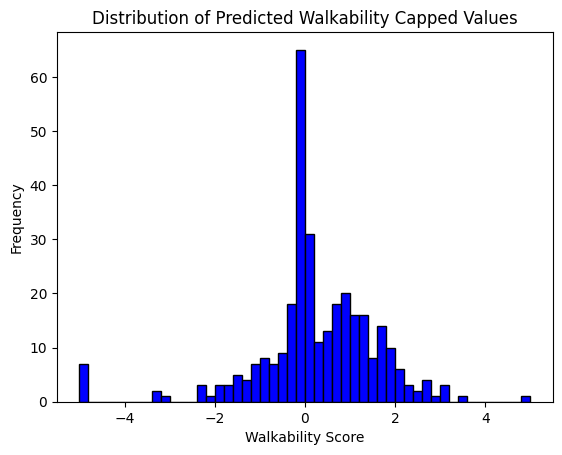

In [ ]:
# Check the distribution of walkability values to fine-tune vmin and vmax
import matplotlib.pyplot as plt

plt.hist(regions_with_walkability['predicted_walkability_capped'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Predicted Walkability Capped Values')
plt.xlabel('Walkability Score')
plt.ylabel('Frequency')
plt.show()


## Comparison with other methods

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold


In [ ]:
# Split the data into training and testing sets
X = X_train_scaled
y = y_train.values

# 80-20 train-test split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_split, y_train_split)


RandomForestRegressor(random_state=42)

In [ ]:

y_pred_rf = rf_model.predict(X_test_split)


In [ ]:
mse_rf = mean_squared_error(y_test_split, y_pred_rf)
mae_rf = mean_absolute_error(y_test_split, y_pred_rf)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.4f}")


Random Forest Regressor Performance:
Mean Squared Error: 0.0406
Mean Absolute Error: 0.1988


In [ ]:
# Initialize the Support Vector Regressor with RBF kernel
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_split, y_train_split)


SVR()

In [ ]:

y_pred_svr = svr_model.predict(X_test_split)


In [ ]:
mse_svr = mean_squared_error(y_test_split, y_pred_svr)
mae_svr = mean_absolute_error(y_test_split, y_pred_svr)

print("\nSupport Vector Regressor Performance:")
print(f"Mean Squared Error: {mse_svr:.4f}")
print(f"Mean Absolute Error: {mae_svr:.4f}")



Support Vector Regressor Performance:
Mean Squared Error: 0.0602
Mean Absolute Error: 0.2206


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Dense(64, input_dim=X_train_split.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:

history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_test_split, y_test_split),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.7782 - mae: 1.6471 - val_loss: 1.2327 - val_mae: 1.0622
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 4.4874 - mae: 1.8720 - val_loss: 1.2253 - val_mae: 1.0586
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 3.5232 - mae: 1.6103 - val_loss: 1.2242 - val_mae: 1.0578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.6549 - mae: 1.6022 - val_loss: 1.2253 - val_mae: 1.0583
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 3.0095 - mae: 1.4433 - val_loss: 1.2226 - val_mae: 1.0569
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 3.4932 - mae: 1.6234 - val_loss: 1.2163 - val_mae: 1.0537
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 4.6544 - mae: 1.6921 - val_loss: 1.2178 - val_mae: 1.0543
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 3.2406 - mae: 1.6189 - val_loss: 1.2139 - val_mae: 1.0523
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 4.9357 -

In [ ]:

y_pred_nn = model.predict(X_test_split).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [ ]:
mse_nn = mean_squared_error(y_test_split, y_pred_nn)
mae_nn = mean_absolute_error(y_test_split, y_pred_nn)

print("\nNeural Network Performance:")
print(f"Mean Squared Error: {mse_nn:.4f}")
print(f"Mean Absolute Error: {mae_nn:.4f}")



Neural Network Performance:
Mean Squared Error: 1.0478
Mean Absolute Error: 1.0005


In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Support Vector Machine', 'Neural Network'],
    'Mean Squared Error': [mse_rf, mse_svr, mse_nn],
    'Mean Absolute Error': [mae_rf, mae_svr, mae_nn]
})

print("\nModel Comparison:")
print(results)



Model Comparison:
                    Model  Mean Squared Error  Mean Absolute Error
0           Random Forest            0.040603             0.198810
1  Support Vector Machine            0.060160             0.220587
2          Neural Network            1.047769             1.000473


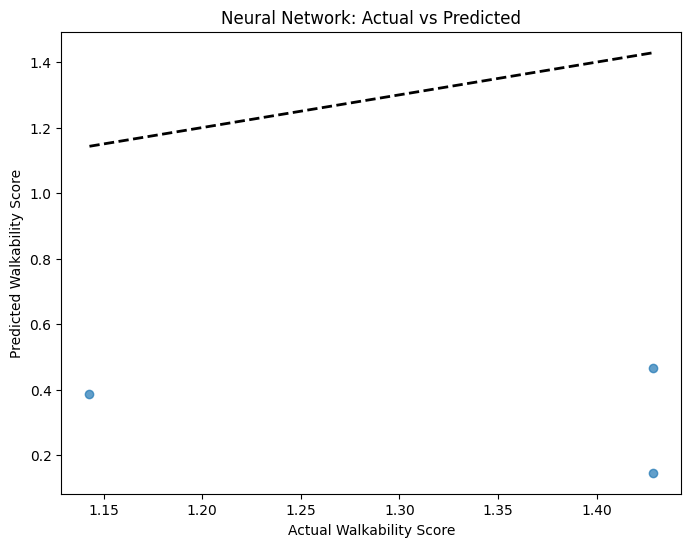

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for Neural Network
plt.figure(figsize=(8, 6))
plt.scatter(y_test_split, y_pred_nn, alpha=0.7)
plt.plot([y_test_split.min(), y_test_split.max()], [y_test_split.min(), y_test_split.max()], 'k--', lw=2)
plt.xlabel('Actual Walkability Score')
plt.ylabel('Predicted Walkability Score')
plt.title('Neural Network: Actual vs Predicted')
plt.show()



In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Evaluate Random Forest using cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
rf_cv_mse = -rf_cv_scores.mean()

print(f"\nRandom Forest Cross-Validated MSE: {rf_cv_mse:.4f}")



Random Forest Cross-Validated MSE: 0.1066


In [ ]:
# Evaluate SVR using cross-validation
svr_cv_scores = cross_val_score(svr_model, X, y, cv=kf, scoring='neg_mean_squared_error')
svr_cv_mse = -svr_cv_scores.mean()

print(f"Support Vector Machine Cross-Validated MSE: {svr_cv_mse:.4f}")


Support Vector Machine Cross-Validated MSE: 0.1375


For all regions

In [ ]:
X_all = features_all_regions[feature_columns]
X_all_scaled = scaler.transform(X_all)


In [ ]:
predicted_walkability_rf = rf_model.predict(X_all_scaled)
features_all_regions['predicted_walkability_rf'] = predicted_walkability_rf


In [ ]:
predicted_walkability_svr = svr_model.predict(X_all_scaled)
features_all_regions['predicted_walkability_svr'] = predicted_walkability_svr


In [ ]:
predicted_walkability_nn = model.predict(X_all_scaled).flatten()
features_all_regions['predicted_walkability_nn'] = predicted_walkability_nn


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:

regions_gdf['cadregion'] = regions_gdf['cadregion'].astype(str).str.strip()


regions_with_walkability = regions_gdf.merge(
    features_all_regions[['cadregion', 'predicted_walkability_rf', 'predicted_walkability_svr', 'predicted_walkability_nn']],
    on='cadregion', how='left'
)


In [ ]:
def plot_walkability_map(column, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    regions_with_walkability.plot(
        column=column,
        cmap='coolwarm',
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.5
    )
    leg = ax.get_legend()
    if leg:
        leg.set_bbox_to_anchor((1.15, 0.5))
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')
    plt.show()
